In [3]:
from data_pipeline.pipeline import DevelopmentPipeline

import polars as pl
import numpy as np
import pandas as pd

from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

input_data_path = os.getenv("INPUT_DATA_PATH")

from catboost import CatBoostClassifier, Pool
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [4]:
dataset = DevelopmentPipeline(input_data_path=input_data_path, data_source='local').run()

In [5]:
dataset.steps

['Load CSV from local file using polars',
 'Casting data types of a polars dataset',
 'Forward-Fill missing information in a polars dataset with date column ordering for each ticker',
 'Create technical indicators for each ticker',
 'Enriching the dataset with row-level features',
 'Creating target variable for each ticker',
 'Creating features for each ticker',
 'Creating time features for each row',
 'Dropping rows with null target values',
 'Splitting data into training, validation, calibration and test sets']

In [6]:
for i in range(len(dataset.steps)):
    print(f"Step {i+1}: {dataset.steps[i]}")
    print(f"Shape: {dataset.shape[i]}")
    print(f"Columns: {dataset.columns[i]}")
    print("----------------------------------")

Step 1: Load CSV from local file using polars
Shape: [('full_df', (4259544, 7))]
Columns: [('full_df', ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker'])]
----------------------------------
Step 2: Casting data types of a polars dataset
Shape: [('full_df', (4259544, 7))]
Columns: [('full_df', ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker'])]
----------------------------------
Step 3: Forward-Fill missing information in a polars dataset with date column ordering for each ticker
Shape: [('full_df', (6175909, 7))]
Columns: [('full_df', ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker'])]
----------------------------------
Step 4: Create technical indicators for each ticker
Shape: [('full_df', (6175909, 17))]
Columns: [('full_df', ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker', 'Close_weighted_moving_avg_ratios', 'RSI', 'bollinger_interval_ratio', 'stochastic_oscillator', 'atr', 'adx', 'CCI', 'tenkan_kijun', 'senkou_cloud', 'chinkou'])]
------

In [7]:
target_threshold = 1.05
xtrain, ytrain = dataset.data['train'].drop(['target', 'Date', 'Ticker']), (dataset.data['train']['target'] >= target_threshold).cast(pl.Int64)
xval, yval = dataset.data['validation'].drop(['target', 'Date', 'Ticker']), (dataset.data['validation']['target'] >= target_threshold).cast(pl.Int64)
xcal, ycal = dataset.data['calibration'].drop(['target', 'Date', 'Ticker']), (dataset.data['calibration']['target'] >= target_threshold).cast(pl.Int64)
xtest, ytest = dataset.data['test'].drop(['target', 'Date', 'Ticker']), (dataset.data['test']['target'] >= target_threshold).cast(pl.Int64)

print(ytrain.mean(), yval.mean(), ycal.mean(), ytest.mean())
#train a dummy classifier

print("Random classifier")
dummy = DummyClassifier(strategy='uniform')
dummy.fit(xtrain.to_pandas(), ytrain.to_pandas())
dummy_preds = dummy.predict(xval.to_pandas())
print(f"Dummy accuracy: {accuracy_score(yval.to_pandas().values, dummy_preds)}")
print(f"Dummy precision: {precision_score(yval.to_pandas().values, dummy_preds)}")
print(f"Dummy recall: {recall_score(yval.to_pandas().values, dummy_preds)}")
print(f"Dummy f1: {f1_score(yval.to_pandas().values, dummy_preds)}")

print("Most frequent classifier")
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(xtrain.to_pandas(), ytrain.to_pandas())
dummy_preds = dummy.predict(xval.to_pandas())
print(f"Dummy accuracy: {accuracy_score(yval.to_pandas().values, dummy_preds)}")
print(f"Dummy precision: {precision_score(yval.to_pandas().values, dummy_preds)}")
print(f"Dummy recall: {recall_score(yval.to_pandas().values, dummy_preds)}")
print(f"Dummy f1: {f1_score(yval.to_pandas().values, dummy_preds)}")

0.17418797484380497 0.16941859632304734 0.21453583934824555 0.18409924551933915
Random classifier
Dummy accuracy: 0.49947936465960363
Dummy precision: 0.168903433381815
Dummy recall: 0.4984878540535267
Dummy f1: 0.2523146814586814
Most frequent classifier
Dummy accuracy: 0.8305814036769527
Dummy precision: 0.0
Dummy recall: 0.0
Dummy f1: 0.0


/Users/santiagoct/Desktop/stock_project/stock_rankings/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
train_pool = Pool(data = xtrain.to_pandas(), label = ytrain.to_pandas(), feature_names=xtrain.columns) #, cat_features=['Ticker'])
val_pool = Pool(data = xval.to_pandas(), label = yval.to_pandas(), feature_names=xval.columns) #, cat_features=['Ticker'])
cal_pool = Pool(data = xcal.to_pandas(), label = ycal.to_pandas(), feature_names=xcal.columns) #, cat_features=['Ticker'])
test_pool = Pool(data = xtest.to_pandas(), label = ytest.to_pandas(), feature_names=xtest.columns) #, cat_features=['Ticker'])

del xtrain, ytrain, xval, yval, xcal, ycal, xtest, ytest

model = CatBoostClassifier(iterations=1_000,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='Logloss',
                           custom_metric=['F1', 'Accuracy', 'Recall', 'Precision', 'BalancedAccuracy', 'BalancedErrorRate'],
                           verbose=False)
model.fit(train_pool, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [26]:
score = model.predict_proba(cal_pool)[:, 1]
y_true = cal_pool.get_label()
n_bins = 10
strategy = 'uniform'

In [27]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_true, score, n_bins=n_bins, strategy=strategy)

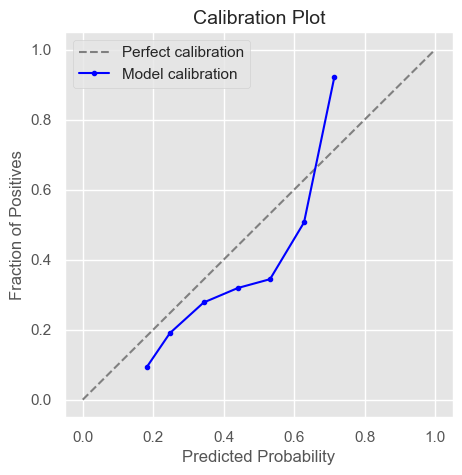

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic appearance of the plots (you can choose other styles like 'whitegrid', 'dark', etc.)
plt.style.use('ggplot')
# Creating the figure and axes object
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the size to fit your specific needs

# Plotting the reference line for perfect calibration
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')

# Plotting the model calibration curve
ax.plot(prob_pred, prob_true, marker='.', linestyle='-', color='blue', label='Model calibration')

# Adding labels, title and legend
ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration Plot', fontsize=14)
ax.legend(loc='best')

# Show the plot
plt.show()

In [40]:
from sklearn.isotonic import IsotonicRegression
iso_reg = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(score, y_true)
proba_test_cb_isoreg = iso_reg.predict(model.predict_proba(test_pool)[:, 1])

In [42]:
#plot calibrated predictions
prob_true, prob_pred = calibration_curve(test_pool.get_label(), proba_test_cb_isoreg, n_bins=n_bins, strategy=strategy)

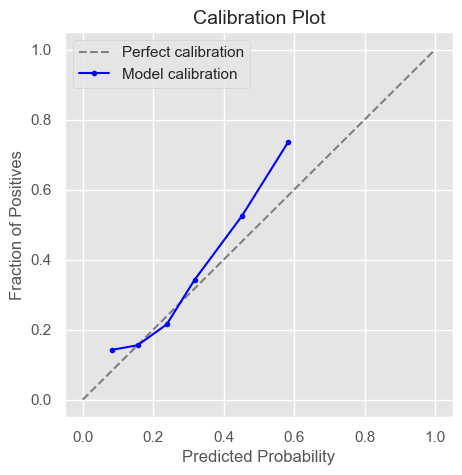

In [43]:
# Set the aesthetic appearance of the plots (you can choose other styles like 'whitegrid', 'dark', etc.)
plt.style.use('ggplot')
# Creating the figure and axes object
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the size to fit your specific needs

# Plotting the reference line for perfect calibration
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')

# Plotting the model calibration curve
ax.plot(prob_pred, prob_true, marker='.', linestyle='-', color='blue', label='Model calibration')

# Adding labels, title and legend
ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration Plot', fontsize=14)
ax.legend(loc='best')

# Show the plot
plt.show()

In [ ]:
def expected_calibration_error(y, proba, bins='fd'):
    import numpy as np  # Import numpy for numerical operations

    # Compute the histogram of predicted probabilities to determine the bins
    bin_count, bin_edges = np.histogram(proba, bins=bins)
    n_bins = len(bin_count)  # Number of bins

    # Adjust the first bin edge slightly to include the exact minimum probability
    bin_edges[0] -= 1e-8

    # Assign each probability to a bin
    bin_id = np.digitize(proba, bin_edges, right=True) - 1

    # Calculate the sum of true labels for each bin
    bin_ysum = np.bincount(bin_id, weights=y, minlength=n_bins)

    # Calculate the sum of probabilities for each bin
    bin_probasum = np.bincount(bin_id, weights=proba, minlength=n_bins)

    # Calculate the average of true labels in each bin
    bin_ymean = np.divide(bin_ysum, bin_count, out=np.zeros(n_bins), where=bin_count > 0)

    # Calculate the average of probabilities in each bin
    bin_probamean = np.divide(bin_probasum, bin_count, out=np.zeros(n_bins), where=bin_count > 0)

    # Calculate the Expected Calibration Error (ECE)
    ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)

    # Return the ECE
    return ece


In [46]:
expected_calibration_error(test_pool.get_label(), proba_test_cb_isoreg)

0.03026087712512709

In [47]:
expected_calibration_error(y_true, score)

0.07229403520473128

In [18]:
import shap
shap.initjs()

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(dataset.data['validation'].drop(['target', 'Date', 'Ticker']).to_pandas())

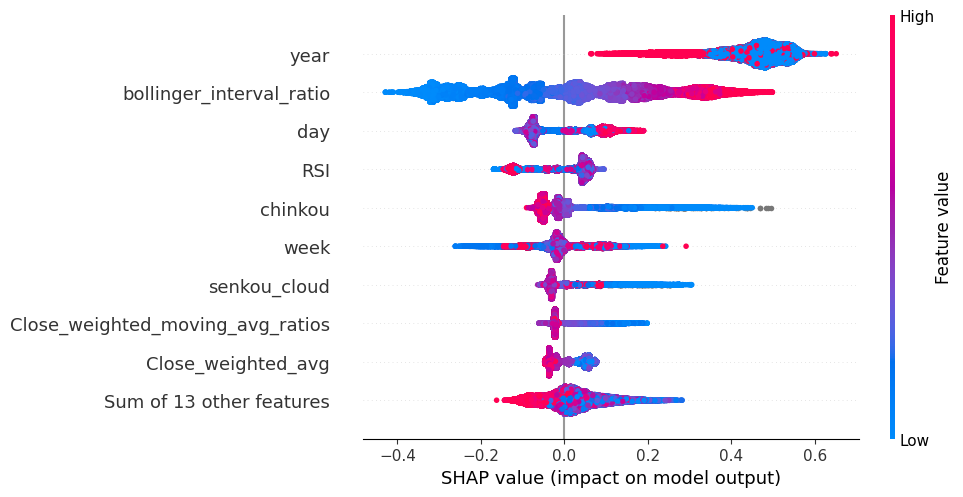

In [20]:
shap.plots.beeswarm(shap_values)